> ## Build models to predict trip duration

We will build a Linear Regression model and a Random Forest model for each borough to predict trip duration for trips that depart at that borough

> Import libraries

In [64]:
%run ../scripts/'modelling.py'
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import RandomForestRegressor
from pyspark.sql.functions import col, avg

In [2]:
spark = (
    SparkSession.builder.appName('MAST30034 Tutorial 3')
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

your 131072x1 screen size is bogus. expect trouble
24/08/24 19:29:40 WARN Utils: Your hostname, LAPTOP-LVDQD9N6 resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
24/08/24 19:29:40 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/24 19:29:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


> Read datasets

In [7]:
train_df = spark.read.parquet('../data/analysis/merged_train.parquet')
test_df = spark.read.parquet('../data/analysis/merged_test.parquet')

In [4]:
# Read taxi zone dataset
zones = spark.read.csv("../data/landing/taxi_zones/taxi+_zone_lookup.csv", header=True, inferSchema=True)
zones.limit(5)

LocationID,Borough,Zone,service_zone
1,EWR,Newark Airport,EWR
2,Queens,Jamaica Bay,Boro Zone
3,Bronx,Allerton/Pelham G...,Boro Zone
4,Manhattan,Alphabet City,Yellow Zone
5,Staten Island,Arden Heights,Boro Zone


In [5]:
# Get all the Borough names
boroughs = zones.select("Borough").distinct().rdd.flatMap(lambda x: x).collect()
print(boroughs)

['Queens', 'EWR', 'Unknown', 'Brooklyn', 'Staten Island', 'Manhattan', 'Bronx']


In [6]:
# We are not considering the 'Unknown' region so we can remove them
boroughs.remove('Unknown')
print(boroughs)

['Queens', 'EWR', 'Brooklyn', 'Staten Island', 'Manhattan', 'Bronx']


Split datasets into each borough

We will split the training and testing datasets into different dataframes based on the borough where the trip started (picked up location). Then save the dataframe of each borough in ..data/analysis

In [7]:
def split_boroughs (sdf, set_name, zones, boroughs):
    '''Get the borough name for each trip in the given dataframe and
    then split the dataframe based on borough name, save each dataframe to ../data/analysis'''

    # Get the borough name where each trip started first
    df_with_boroughs = sdf.join(zones, sdf.pulocationid == zones.LocationID, "inner")
    df_with_boroughs = df_with_boroughs.drop(*['LocationID', 'Zone', 'service_zone'])
    
    # Start splitting the dataframe based on boroughs
    for borough in boroughs:
        current_borough_df = df_with_boroughs.filter(df_with_boroughs["Borough"] == borough)
        
        # Output to analysis layer
        current_borough_df \
        .coalesce(1) \
        .write \
        .mode('overwrite') \
        .parquet(f'../data/analysis/{set_name}/{borough}.parquet')

In [ ]:
# Split training set based on borough 
split_boroughs(train_df, 'train', zones, boroughs)

In [ ]:
# Split testing set based on borough 
split_boroughs(test_df, 'test', zones, boroughs)

In [3]:
# Read all the dataframes by borough for training set
train_queens = spark.read.parquet('../data/analysis/train/Queens.parquet')
train_bronx = spark.read.parquet('../data/analysis/train/Bronx.parquet')
train_EWR = spark.read.parquet('../data/analysis/train/EWR.parquet')
train_brooklyn = spark.read.parquet('../data/analysis/train/Brooklyn.parquet')
train_manhattan = spark.read.parquet('../data/analysis/train/Manhattan.parquet')
train_staten = spark.read.parquet('../data/analysis/train/Staten Island.parquet')

In [6]:
print("Number of instances in training dataset at Queens:", train_queens.count())
print("Number of instances in training dataset at Bronx:", train_bronx.count())
print("Number of instances in training dataset at EWR:", train_EWR.count())
print("Number of instances in training dataset at Brooklyn:", train_brooklyn.count())
print("Number of instances in training dataset at Manhattan:", train_manhattan.count())
print("Number of instances in training dataset at Staten Island:", train_staten.count())

Number of instances in training dataset at Queens: 1588880
Number of instances in training dataset at Bronx: 19478
Number of instances in training dataset at EWR: 70
Number of instances in training dataset at Brooklyn: 104351
Number of instances in training dataset at Manhattan: 12879723
Number of instances in training dataset at Staten Island: 985


In [4]:
# Read all the dataframes by borough for testing set
test_queens = spark.read.parquet('../data/analysis/test/Queens.parquet')
test_bronx = spark.read.parquet('../data/analysis/test/Bronx.parquet')
test_EWR = spark.read.parquet('../data/analysis/test/EWR.parquet')
test_brooklyn = spark.read.parquet('../data/analysis/test/Brooklyn.parquet')
test_manhattan = spark.read.parquet('../data/analysis/test/Manhattan.parquet')
test_staten = spark.read.parquet('../data/analysis/test/Staten Island.parquet')

In [37]:
print("Number of instances in testing dataset at Queens:", test_queens.count())
print("Number of instances in testing dataset at Bronx:", test_bronx.count())
print("Number of instances in testing dataset at EWR:", test_EWR.count())
print("Number of instances in testing dataset at Brooklyn:", test_brooklyn.count())
print("Number of instances in testing dataset at Manhattan:", test_manhattan.count())
print("Number of instances in testing dataset at Staten Island:", test_staten.count())

Number of instances in testing dataset at Queens: 227226
Number of instances in testing dataset at Bronx: 6051
Number of instances in testing dataset at EWR: 17
Number of instances in testing dataset at Brooklyn: 25269
Number of instances in testing dataset at Manhattan: 2112329
Number of instances in testing dataset at Staten Island: 35


> Fitting Models for each borough

>> Models for Queens

We will first prepare a pipeline to apply one-hot encoding the categorical features such as pick up locations or hour in a day. For continuous features, we will standardise them to have a mean of 0 and std 1.

In [52]:
train_prepared, test_prepared = fit_pipeline(train_queens, test_queens)     # function from modelling.py

>>> Fit Linear Regression for Queens

In [53]:
lr = LinearRegression(featuresCol="scaled_features", labelCol="trip_duration")

In [62]:
# Make predictions for trip duration in Queens using Linear Regression
lr_queens_pred = make_predictions(train_prepared, test_prepared, lr)    # function from modelling.py

24/08/24 20:45:20 WARN Instrumentation: [e8bffddc] regParam is zero, which might cause numerical instability and overfitting.
24/08/24 20:45:25 WARN Instrumentation: [e8bffddc] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


In [63]:
# Evaluate the Linear Regression model's predictions using Mean Absolute Error
mae = get_mae(lr_queens_pred)
print(f"Mean Absolute Error (MAE) in Queens using Linear Regression: {mae}")

Mean Absolute Error (MAE) in Queens using Linear Regression: 6.757307032553398


>>> Fit Random Forest for Queens

In [58]:
rf = RandomForestRegressor(featuresCol="scaled_features", labelCol="trip_duration")

In [59]:
# Make predictions for trip duration in Queens using Random Forest
rf_queens_pred = make_predictions(train_prepared, test_prepared, rf)    # function from modelling.py

24/08/24 20:42:08 WARN MemoryStore: Not enough space to cache rdd_830_3 in memory! (computed 250.9 MiB so far)
24/08/24 20:42:08 WARN BlockManager: Persisting block rdd_830_3 to disk instead.
24/08/24 20:42:24 WARN MemoryStore: Not enough space to cache rdd_830_3 in memory! (computed 250.9 MiB so far)
24/08/24 20:42:45 WARN MemoryStore: Not enough space to cache rdd_830_3 in memory! (computed 250.9 MiB so far)
24/08/24 20:43:08 WARN MemoryStore: Not enough space to cache rdd_830_3 in memory! (computed 250.9 MiB so far)
24/08/24 20:43:32 WARN MemoryStore: Not enough space to cache rdd_830_3 in memory! (computed 250.9 MiB so far)
24/08/24 20:43:58 WARN MemoryStore: Not enough space to cache rdd_830_3 in memory! (computed 250.9 MiB so far)


In [61]:
# Evaluate the Linear Regression model's predictions using Mean Absolute Error
mae = get_mae(rf_queens_pred)
print(f"Mean Absolute Error (MAE) in Queens using Random Forest: {mae}")

Mean Absolute Error (MAE) in Queens using Random Forest: 8.708331070368049


For visualisation, we will choose a random day in the test set to graph the average predicted speed vs the average actual speed in that day.

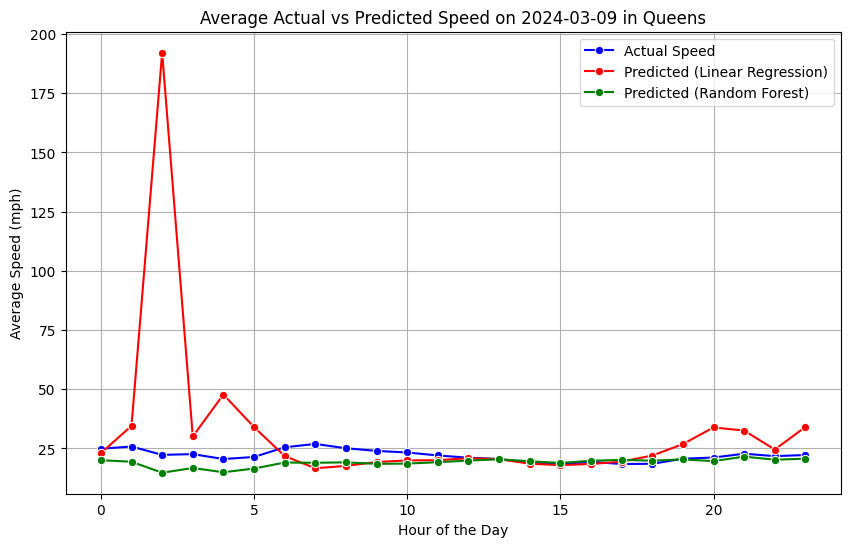

In [66]:
# Graph for Queens
random_date = get_random_day(test_queens)
predict_vs_actual('Queens', lr_queens_pred, rf_queens_pred, random_date)

This plot is saved under ../plots/predicted_queens.png

>> Models for EWR

In [67]:
# Preprocess data for EWR
train_prepared, test_prepared = fit_pipeline(train_EWR, test_EWR)     # function from modelling.py

>>> Fit Linear Regression for 'EWR'

In [68]:
# Make predictions for trip duration in EWR using Linear Regression
lr_ewr_pred = make_predictions(train_prepared, test_prepared, lr)    # function from modelling.py

24/08/24 20:53:19 WARN Instrumentation: [98b12537] regParam is zero, which might cause numerical instability and overfitting.
24/08/24 20:53:19 WARN Instrumentation: [98b12537] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


In [69]:
# Evaluate the model's predictions using Mean Absolute Error
mae = get_mae(lr_ewr_pred)
print(f"Mean Absolute Error (MAE) in EWR using Linear Regression: {mae}")

Mean Absolute Error (MAE) in EWR using Linear Regression: 15.018646553924626


>>> Fit Random Forest for EWR

In [70]:
# Make predictions for trip duration in EWR using Random Forest
rf_ewr_pred = make_predictions(train_prepared, test_prepared, rf)    # function from modelling.py

In [71]:
# Evaluate the model's predictions using Mean Absolute Error
mae = get_mae(rf_ewr_pred)
print(f"Mean Absolute Error (MAE) in EWR using Random Forest: {mae}")

Mean Absolute Error (MAE) in EWR using Random Forest: 9.534871996163227


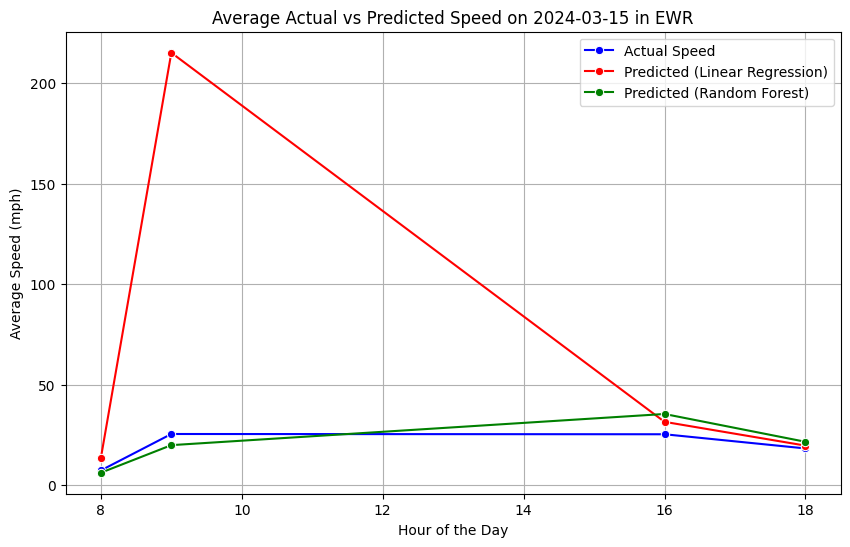

In [72]:
# Graph for EWR
random_date = get_random_day(test_EWR)
predict_vs_actual('EWR', lr_ewr_pred, rf_ewr_pred, random_date)

This plot is saved under ../plots/predicted_ewr.png

>> Models for Bronx

In [73]:
# Preprocess data for Bronx
train_prepared, test_prepared = fit_pipeline(train_bronx, test_bronx)     # function from modelling.py

>>> Linear Regression for Bronx

In [74]:
# Make predictions for trip duration in Bronx using Linear Regression
lr_bronx_pred = make_predictions(train_prepared, test_prepared, lr)    # function from modelling.py

24/08/24 20:56:44 WARN Instrumentation: [87c40a4f] regParam is zero, which might cause numerical instability and overfitting.
24/08/24 20:56:44 WARN Instrumentation: [87c40a4f] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


In [75]:
# Evaluate the model's predictions using Mean Absolute Error
mae = get_mae(lr_bronx_pred)
print(f"Mean Absolute Error (MAE) in Bronx using Linear Regression: {mae}")

Mean Absolute Error (MAE) in Bronx using Linear Regression: 11.646713120822485


>>> Random Forest for Bronx

In [76]:
# Make predictions for trip duration in Bronx using Random Forest
rf_bronx_pred = make_predictions(train_prepared, test_prepared, rf)    # function from modelling.py

In [77]:
# Evaluate the model's predictions using Mean Absolute Error
mae = get_mae(rf_bronx_pred)
print(f"Mean Absolute Error (MAE) in Bronx using Random Forest: {mae}")

Mean Absolute Error (MAE) in Bronx using Random Forest: 13.000573209761301


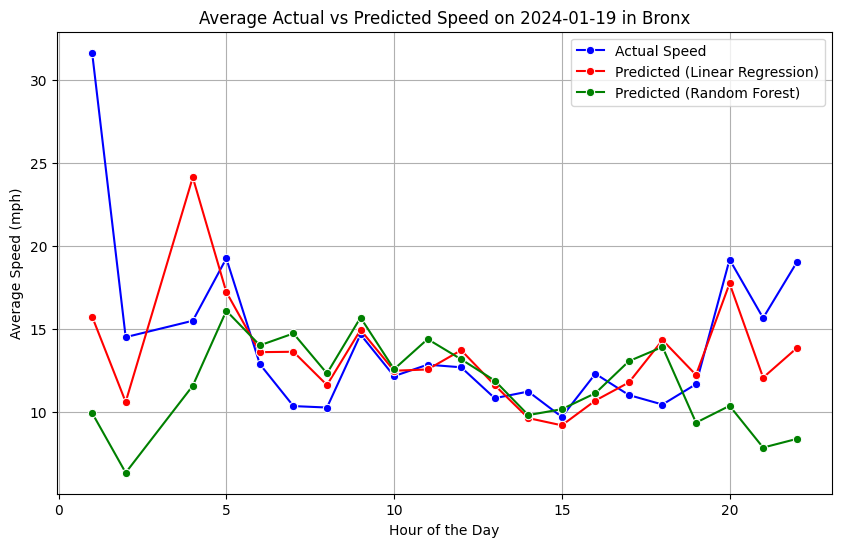

In [79]:
# Graph for Bronx
random_date = get_random_day(test_bronx)
predict_vs_actual('Bronx', lr_bronx_pred, rf_bronx_pred, random_date)

This plot is saved under ../plots/predicted_bronx.png

>> Models for Brooklyn

In [80]:
# Preprocess data for Brooklyn
train_prepared, test_prepared = fit_pipeline(train_brooklyn, test_brooklyn)     # function from modelling.py

>>> Linear Regression for Brooklyn

In [81]:
# Make predictions for trip duration in Brooklyn using Linear Regression
lr_brooklyn_pred = make_predictions(train_prepared, test_prepared, lr)    # function from modelling.py

24/08/24 21:00:26 WARN Instrumentation: [0f9f5d7d] regParam is zero, which might cause numerical instability and overfitting.
24/08/24 21:00:26 WARN Instrumentation: [0f9f5d7d] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


In [82]:
# Evaluate the model's predictions using Mean Absolute Error
mae = get_mae(lr_brooklyn_pred)
print(f"Mean Absolute Error (MAE) in Brooklyn using Linear Regression: {mae}")

Mean Absolute Error (MAE) in Brooklyn using Linear Regression: 9.450943248126887


>>> Random Forest for Brooklyn

In [83]:
# Make predictions for trip duration in Brooklyn using Random Forest
rf_brooklyn_pred = make_predictions(train_prepared, test_prepared, rf)    # function from modelling.py

In [84]:
# Evaluate the model's predictions using Mean Absolute Error
mae = get_mae(rf_brooklyn_pred)
print(f"Mean Absolute Error (MAE) in Brooklyn using Random Forest: {mae}")

Mean Absolute Error (MAE) in Brooklyn using Random Forest: 11.03327864206262


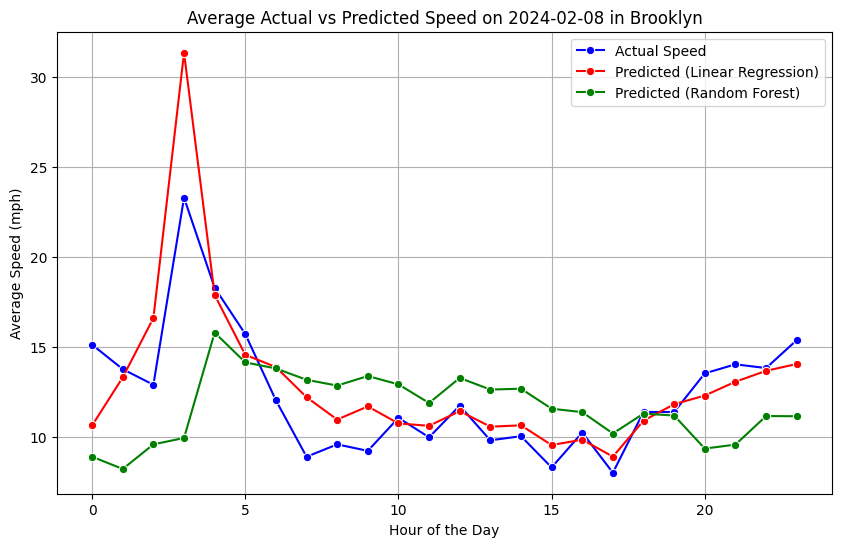

In [86]:
# Graph for Brooklyn
random_date = get_random_day(test_brooklyn)
predict_vs_actual('Brooklyn', lr_brooklyn_pred, rf_brooklyn_pred, random_date)

This plot is saved under ../plots/predicted_brooklyn.png

>> Models for Manhattan

In [87]:
# Preprocess data for Manhattan
train_prepared, test_prepared = fit_pipeline(train_manhattan, test_manhattan)     # function from modelling.py

>>> Linear Regression for Manhattan

In [88]:
# Make predictions for trip duration in Manhattan using Linear Regression
lr_manhattan_pred = make_predictions(train_prepared, test_prepared, lr)    # function from modelling.py

24/08/24 21:04:34 WARN Instrumentation: [437e6c07] regParam is zero, which might cause numerical instability and overfitting.
24/08/24 21:04:58 WARN Instrumentation: [437e6c07] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


In [89]:
# Evaluate the model's predictions using Mean Absolute Error
mae = get_mae(lr_manhattan_pred)
print(f"Mean Absolute Error (MAE) in Manhattan using Linear Regression: {mae}")

Mean Absolute Error (MAE) in Manhattan using Linear Regression: 3.7557283423502006


>>> Random Forest for Manhattan

In [90]:
# Make predictions for trip duration in Manhattan using Random Forest
rf_manhattan_pred = make_predictions(train_prepared, test_prepared, rf)    # function from modelling.py

24/08/24 21:07:10 WARN MemoryStore: Not enough space to cache rdd_1464_7 in memory! (computed 110.4 MiB so far)
24/08/24 21:07:10 WARN BlockManager: Persisting block rdd_1464_7 to disk instead.
24/08/24 21:07:10 WARN MemoryStore: Not enough space to cache rdd_1464_1 in memory! (computed 110.4 MiB so far)
24/08/24 21:07:10 WARN BlockManager: Persisting block rdd_1464_1 to disk instead.
24/08/24 21:07:10 WARN MemoryStore: Not enough space to cache rdd_1464_5 in memory! (computed 110.4 MiB so far)
24/08/24 21:07:10 WARN BlockManager: Persisting block rdd_1464_5 to disk instead.
24/08/24 21:07:33 WARN MemoryStore: Not enough space to cache rdd_1464_7 in memory! (computed 249.6 MiB so far)
24/08/24 21:08:31 WARN MemoryStore: Not enough space to cache rdd_1464_1 in memory! (computed 166.4 MiB so far)
24/08/24 21:08:31 WARN MemoryStore: Not enough space to cache rdd_1464_5 in memory! (computed 166.4 MiB so far)
24/08/24 21:10:17 WARN MemoryStore: Not enough space to cache rdd_1464_1 in memory

In [91]:
# Evaluate the model's predictions using Mean Absolute Error
mae = get_mae(rf_manhattan_pred)
print(f"Mean Absolute Error (MAE) in Manhattan using Random Forest: {mae}")

Mean Absolute Error (MAE) in Manhattan using Random Forest: 4.164024332528832


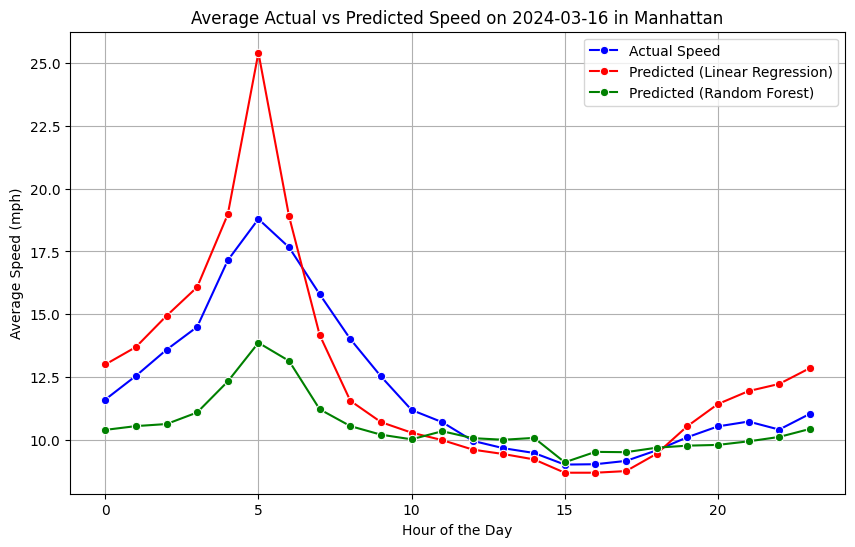

In [93]:
# Graph for Manhattan
random_date = get_random_day(test_manhattan)
predict_vs_actual('Manhattan', lr_manhattan_pred, rf_manhattan_pred, random_date)

This plot is saved under ../plots/predicted_manhattan.png

>> Models for Staten Island

In [94]:
# Preprocess data for Staten Island
train_prepared, test_prepared = fit_pipeline(train_staten, test_staten)     # function from modelling.py

>>> Linear Regression for Staten Island

In [95]:
# Make predictions for trip duration in Staten Island using Linear regression
lr_staten_pred = make_predictions(train_prepared, test_prepared, lr)    # function from modelling.py

24/08/24 21:21:12 WARN Instrumentation: [aa9b2d6e] regParam is zero, which might cause numerical instability and overfitting.
24/08/24 21:21:12 WARN Instrumentation: [aa9b2d6e] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


In [96]:
# Evaluate the model's predictions using Mean Absolute Error
mae = get_mae(lr_staten_pred)
print(f"Mean Absolute Error (MAE) in Staten Island using Linear Regression: {mae}")

Mean Absolute Error (MAE) in Staten Island using Linear Regression: 15.817912263698489


>>> Random Forest for Staten Island

In [97]:
# Make predictions for trip duration in Staten Island using Random Forest
rf_staten_pred = make_predictions(train_prepared, test_prepared, rf)    # function from modelling.py

In [98]:
# Evaluate the model's predictions using Mean Absolute Error
mae = get_mae(rf_staten_pred)
print(f"Mean Absolute Error (MAE) in Staten Island using Random Forest: {mae}")

Mean Absolute Error (MAE) in Staten Island using Random Forest: 14.949233946867723


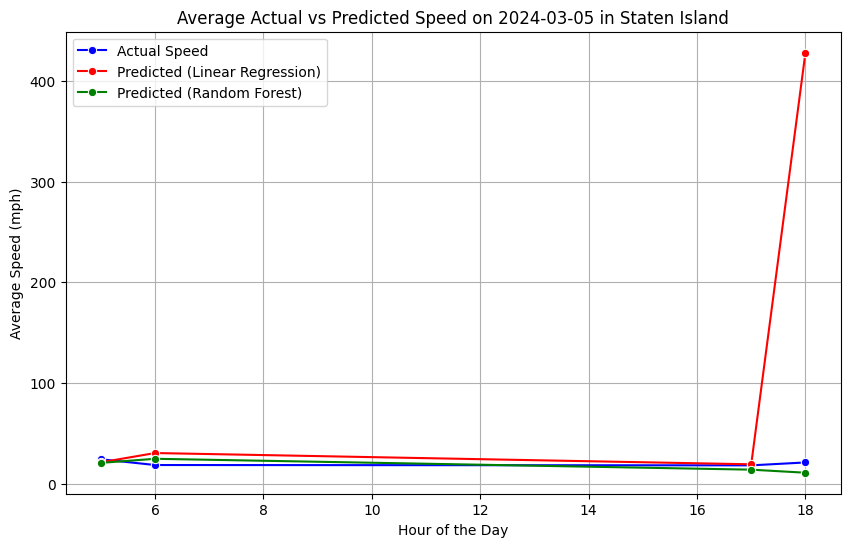

In [99]:
# Graph for Staten Island
random_date = get_random_day(test_staten)
predict_vs_actual('Staten Island', lr_staten_pred, rf_staten_pred, random_date)

This plot is saved under ../plots/predicted_staten.png